# NDT Global - Technical Assessment Machine Learning Engineer

In [14]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

import tensorflow as tf
#from tensorflow.keras import layers, models
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [15]:
# Check if GPU is available (Apple's Metal backend)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


Define a custom dataloader optimsed for data augmentation with transforamtions

In [16]:
##################################################################
# CustomImageDataset() :: Custom dataset class to load images    #
##################################################################
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels_df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        image_id = str(self.labels_df.iloc[idx, 0])         # image_id column
        has_gw = self.labels_df.iloc[idx, 1]                # hasGW column
        dangerous_feature_id = self.labels_df.iloc[idx, 2]  # dangerous_feature_id column

        img_path = os.path.join(self.img_dir, f"{image_id}.png")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        # labels to tensor
        labels = torch.tensor([has_gw, dangerous_feature_id], dtype=torch.float32)

        return image, labels



In [17]:
##########################################################################################
# split_data() ::  Function to split data into training, validation and test sets        #
##########################################################################################
def split_data(dataset, test_split=0.1, val_split=0.1, shuffle=True, seed=37):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    
    # Calculate split sizes
    test_size = int(np.floor(test_split * dataset_size))
    val_size = int(np.floor(val_split * (dataset_size - test_size)))  # Validation based on remaining data
    
    if shuffle:
        random.seed(seed)
        random.shuffle(indices)
    
    test_indices = indices[:test_size]
    remaining_indices = indices[test_size:]
    
    val_indices = remaining_indices[:val_size]
    train_indices = remaining_indices[val_size:]
    
    return train_indices, val_indices, test_indices

Function to train a model

In [18]:
#####################################################################################################################
#  train_model() :: Training function                                                                               #
#      patience   :: Training will stop if no significant improvement takes place in "patience" epochs.             #
#      threshold  :: Relative improvement required for validation acc or loss to reset the patience counter.        #
#####################################################################################################################
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, scheduler, patience=35, threshold=0.02, save_path="./Model/Simple-CNN/", save_name="model.pth"):
    
    # Keep track of training and validation loss
    valid_accuracy_max = 0                       # Initialize max validation accuracy
    valid_loss_min = np.Inf                      # Initialize minimum validation loss
    train_losses, valid_losses = [], []          # Store loss values for plotting
    train_accuracies, valid_accuracies = [], []  # Store accuracy values for plotting
    no_improvement_epochs = 0                    # Initialize patience counter

    device = 'cpu'
    
    for epoch in range(1, num_epochs+1):

        ###################
        # train the model # --> train_loader
        ###################
        model.train()  # Set the model to training mode
        train_loss = 0.0
        valid_loss = 0.0
        correct_train_gw = 0  # Track correct predictions for hasGW
        correct_train_dangerous = 0  # Track correct predictions for dangerous_feature_id
        total_train = 0        
        
        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Split labels into two parts: hasGW and dangerous_feature_id
            hasGW_labels = labels[:, 0].unsqueeze(1)  # First column is hasGW
            dangerous_labels = labels[:, 1].unsqueeze(1)  # Second column is dangerous_feature_id

            optimizer.zero_grad()  # Clear the gradients

            # Forward pass, calculate output
            hasGW_output, dangerous_output = model(images)

            # Calculate losses for both heads
            loss_gw = criterion(hasGW_output, hasGW_labels)
            loss_dangerous = criterion(dangerous_output, dangerous_labels)
            loss = loss_gw + loss_dangerous  # Sum of both losses

            # Backpropagation
            loss.backward()
            optimizer.step()  # Update weights

            train_loss += loss.item() * images.size(0)  # Track training loss

            # Calculate training accuracy for both heads
            hasGW_pred = torch.round(torch.sigmoid(hasGW_output))  # Binary predictions (sigmoid + threshold at 0.5)
            dangerous_pred = torch.round(torch.sigmoid(dangerous_output))  # Binary predictions for dangerous feature

            correct_train_gw += (hasGW_pred == hasGW_labels).sum().item()
            correct_train_dangerous += (dangerous_pred == dangerous_labels).sum().item()
            total_train += labels.size(0)

        ######################
        # validate the model # --> valid_loader
        ######################
        model.eval()  # Set the model to evaluation mode
        correct_valid_gw = 0  # Correct predictions for hasGW in validation
        correct_valid_dangerous = 0  # Correct predictions for dangerous_feature_id in validation
        total_valid = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                # Split labels into two parts: hasGW and dangerous_feature_id
                hasGW_labels = labels[:, 0].unsqueeze(1)
                dangerous_labels = labels[:, 1].unsqueeze(1)

                # Forward pass
                hasGW_output, dangerous_output = model(images)

                # Calculate validation losses for both heads
                loss_gw = criterion(hasGW_output, hasGW_labels)
                loss_dangerous = criterion(dangerous_output, dangerous_labels)
                loss = loss_gw + loss_dangerous

                valid_loss += loss.item() * images.size(0)  # Track validation loss

                # Calculate validation accuracy for both heads
                hasGW_pred = torch.round(torch.sigmoid(hasGW_output))
                dangerous_pred = torch.round(torch.sigmoid(dangerous_output))

                correct_valid_gw += (hasGW_pred == hasGW_labels).sum().item()
                correct_valid_dangerous += (dangerous_pred == dangerous_labels).sum().item()
                total_valid += labels.size(0)

        ###################
        #  Derive metrics #
        ###################
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Calculate training accuracy for both heads (average them)
        train_accuracy_gw = 100 * correct_train_gw / total_train
        train_accuracy_dangerous = 100 * correct_train_dangerous / total_train
        train_accuracy = (train_accuracy_gw + train_accuracy_dangerous) / 2

        # Calculate validation accuracy for both heads (average them)
        valid_accuracy_gw = 100 * correct_valid_gw / total_valid
        valid_accuracy_dangerous = 100 * correct_valid_dangerous / total_valid
        valid_accuracy = (valid_accuracy_gw + valid_accuracy_dangerous) / 2

        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        # Print training/validation statistics
        print(f'\nEpoch: {epoch} \n\tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \n\tTraining Accuracy: {train_accuracy:.2f}% \tValidation Accuracy: {valid_accuracy:.2f}%')

        #####
        # Save the model if validation loss has decreased
        ######
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_full_path = os.path.join(save_path, save_name)
        
        if valid_loss < valid_loss_min:  
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), save_full_path)
            valid_loss_min = valid_loss

        ####
        # Early stop
        ### 
        relative_loss_improvement = (valid_loss_min - valid_loss) / valid_loss_min if valid_loss_min != 0 else 0
        relative_accuracy_improvement = (valid_accuracy - valid_accuracy_max) / valid_accuracy_max if valid_accuracy_max != 0 else 0

        # Check if loss and accuracy improved by more than the threshold
        if (relative_loss_improvement > threshold) or (relative_accuracy_improvement > threshold):
            valid_accuracy_max = valid_accuracy
            no_improvement_epochs = 0  # Reset patience counter 
        else:
            no_improvement_epochs += 1
        
        # Adjust learning rate based on validation loss
        scheduler.step(valid_loss)
        
        if no_improvement_epochs >= patience:
            print(f'Early stopping: No improvement in validation for {patience} epochs.')
            break  

    return train_losses, valid_losses, train_accuracies, valid_accuracies


Functions to create models

In [19]:
###############################################
#  My_CNN() ::                              #
###############################################
class My_CNN(nn.Module):
    def __init__(self):
        super(My_CNN, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # 3x3 kernel, padding to preserve size
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Increase number of filters
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fourth Convolutional Layer (Optional)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Global Average Pooling (instead of Flatten)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Creates a 1x1 image with many channels

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)  # Match input to output channels of the last conv layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Final output for 2 classes

        # Dropout Layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # First Convolutional Block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # Reduce size by half

        # Second Convolutional Block
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Third Convolutional Block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Fourth Convolutional Block (Optional)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Global Average Pooling
        x = self.global_avg_pool(x)  # Reduces to (batch_size, 256, 1, 1) # 256 = number of channels
        x = x.view(x.size(0), -1)    # Flatten to (batch_size, 256)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout for regularization
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer
        
        return x
    
    
#model = My_CNN()
#print(model)

In [20]:
#######
# TwoHeadCNN() :: Using a pre-trained ResNet backbone for better performance
#######
class TwoHeadCNN_pretrained(nn.Module):
    def __init__(self, num_classes_gw=1, num_classes_dangerous=1):
        super(TwoHeadCNN_pretrained, self).__init__()
        
        # Shared convolutional layers (using a pre-trained ResNet backbone for better performance)
        self.resnet_backbone = models.resnet18(pretrained=True)
        
        # Remove the fully connected layer of ResNet18
        num_features = self.resnet_backbone.fc.in_features
        self.resnet_backbone.fc = nn.Identity()  # We replace it with two heads later
        
        # First head (for predicting girth weld presence)
        self.fc_head_gw = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes_gw)  # Binary classification for hasGW
        )
        
        # Second head (for predicting dangerous features)
        self.fc_head_dangerous = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes_dangerous)  # Binary classification for dangerous_feature_id
        )
        
    def forward(self, x):
        # Pass the input through the shared ResNet backbone
        features = self.resnet_backbone(x)
        
        # Two heads
        hasGW_output = self.fc_head_gw(features)
        dangerous_output = self.fc_head_dangerous(features)
        
        return hasGW_output, dangerous_output

# Initialize the model
#model = TwoHeadCNN_pretrained()
#print(model)

In [21]:
class TwoHeadCNN_custom(nn.Module):
    def __init__(self, num_classes1=10, num_classes2=10):
        super(TwoHeadCNN_custom, self).__init__()
        
        # Shared convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # First head (for Task 1)
        self.fc1_head1 = nn.Linear(128, 64)
        self.fc2_head1 = nn.Linear(64, num_classes1)
        
        # Second head (for Task 2)
        self.fc1_head2 = nn.Linear(128, 64)
        self.fc2_head2 = nn.Linear(64, num_classes2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Shared CNN layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128)
        
        # First head
        x1 = F.relu(self.fc1_head1(x))
        x1 = self.dropout(x1)
        x1 = self.fc2_head1(x1)  # Output layer for Task 1
        
        # Second head
        x2 = F.relu(self.fc1_head2(x))
        x2 = self.dropout(x2)
        x2 = self.fc2_head2(x2)  # Output layer for Task 2
        
        return x1, x2

# Example usage:
#model = TwoHeadCNN_custom(num_classes1=2, num_classes2=2)
#print(model)

In [22]:
############################################################################
# plot_images_from_loader() :: Used to test the impact of transformations 
############################################################################
def plot_images_from_loader(loader):
    images, labels = next(iter(loader))
    
    # Set up a 2x3 subplot (for the first 6 images)
    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    
    # Loop through the first 6 images in the batch
    for i, ax in enumerate(axes.flat):
        # Convert the tensor image to a numpy array and adjust for matplotlib
        img = images[i].numpy().transpose(1, 2, 0)
        
        # Denormalize the image if normalization was applied (optional)
        # If you applied normalization, undo it for visualization
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
        
        # Plot the image
        ax.imshow(img)
        
        # Extract the labels for `hasGW` and `dangerous_feature_id`
        hasGW = labels[i, 0].item()
        dangerous_feature = labels[i, 1].item()
        
        # Set the title to show both labels
        ax.set_title(f'hasGW: {hasGW}, Danger: {dangerous_feature}')
        ax.axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()
    
########################################################
# plot_accuracy() :: training and validation accuracy  #
########################################################
def plot_accuracy(train_accuracies, valid_accuracies):
    epochs = range(1, len(train_accuracies) + 1)  # defined like this for the event of early stopping
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

################################################
# plot_loss() :: training and validation loss  #
################################################
def plot_loss(train_losses, valid_losses):
    epochs = range(1, len(train_losses) + 1)  
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [23]:
####################################################################################
# test_model() :: Evaluates the performance of the model on the given test_loader  #
####################################################################################
def test_model(model, test_loader, criterion):
    # Load the weights of the model to test
    #model.load_state_dict(torch.load('./Model/Simple-CNN/model.pth'))
    
    # Set the model to evaluation mode
    model.eval()
    
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    # Turn off gradients for test evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            # Move tensors to GPU if CUDA is available
            #if train_on_gpu:
            #    images, labels = images.cuda(), labels.cuda()

            # Forward pass: compute predictions
            output = model(images)
            
            # Calculate the test loss
            loss = criterion(output, labels)
            test_loss += loss.item() * images.size(0)  # Accumulate the test loss
            
            # Calculate accuracy
            _, predicted = torch.max(output, 1)  # Get predicted class
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    
    # Calculate average test loss
    test_loss = test_loss / len(test_loader.sampler)
    
    # Calculate test accuracy
    test_accuracy = 100 * correct_test / total_test
    
    print(f'\nTest Loss: {test_loss:.6f} \nTest Accuracy: {test_accuracy:.2f}%')

In [24]:
Debug = True

## Data preparation

In [25]:
####################
#   Load the data  #
####################


# Data path
img_dir = 'NDT_Global/Data/images/'
csv_file = 'NDT_Global/Data/labels.csv'

print(os.getcwd())



# Transformations
# Define transformations for train, validation and test datasets
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
])

# No augmentations for validation and test datasets
no_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])





# Create the datasets
train_dataset = CustomImageDataset(img_dir, csv_file, transform=train_transform)
val_dataset = CustomImageDataset(img_dir, csv_file, transform=no_transform)
test_dataset = CustomImageDataset(img_dir, csv_file, transform=no_transform)


# Split data with indices
train_indices, val_indices, test_indices = split_data(train_dataset, test_split=0.1, val_split=0.1)

# Create data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)


batch_size = 32 #reduce if memory issues. Try out batch sizes of 16, 32, and 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=0)

# Confirm the splits
print(f"Number of training samples: {len(train_indices)}")
print(f"Number of validation samples: {len(val_indices)}")
print(f"Number of test samples: {len(test_indices)}")


/Users/pablo/Desktop
Number of training samples: 5578
Number of validation samples: 619
Number of test samples: 688


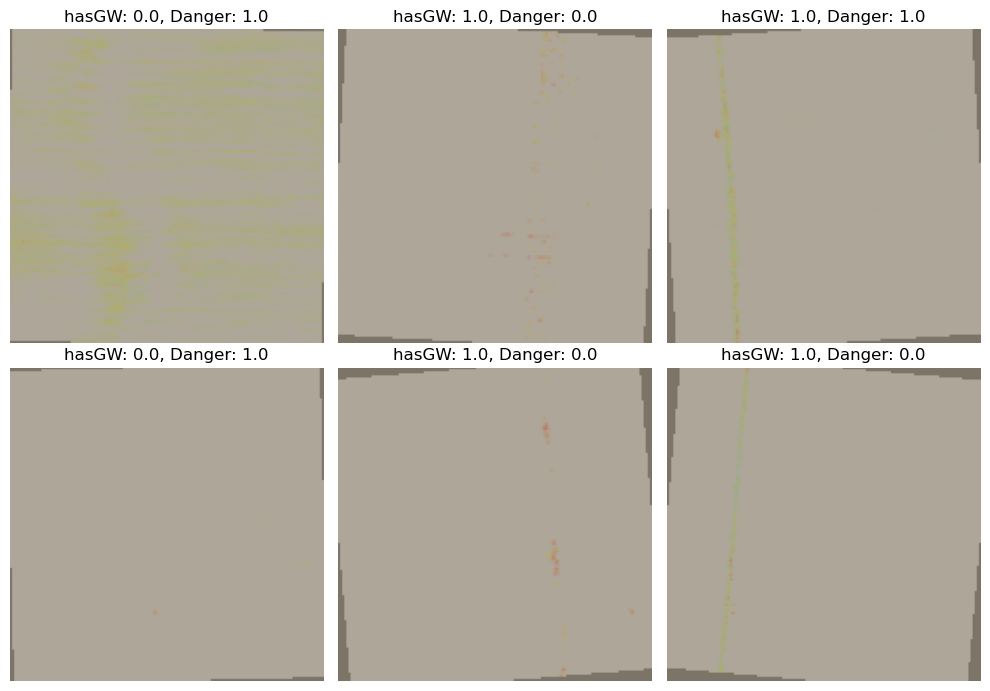

In [26]:
# Test
plot_images_from_loader(train_loader)

## Model training

In [ ]:
####
# choose model
###
model = TwoHeadCNN_pretrained()
print(model)

#########################
# Train hyperparameters
#########################

# Specify loss function (categorical cross-entropy)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits for binary classification

# Specify optimizer. The most popular optimizers are Adam and SGD
#optimizer = optim.SGD(model.parameters(), lr=0.01)            # Stochastic Gradient Descent
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adaptive Moment Estimation

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Number of epochs to train the model
n_epochs = 20

########
#  Start training
##########



train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, val_loader,  
    criterion, optimizer, num_epochs=n_epochs, 
    scheduler=scheduler, patience=100, threshold=0.01, 
    save_path="./Model/Test_CNN/", save_name="model_01.pth"
)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TwoHeadCNN_pretrained(
  (resnet_backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

## Visualizations

In [ ]:
plot_accuracy(train_accuracies, valid_accuracies)

In [ ]:
plot_loss(train_losses, valid_losses)

In [ ]:
test_model(model, test_loader, criterion)
